# Системы хранения и обработки данных. Домашнее задание 4 (vo_HW)

Дано 2 CSV-файла: один с транзакциями за период 01.01.2023 – 20.04.2023, второй с информацией о клиентах.

За дефолтную дату для выборки действующих клиентов брать ‘2023-05-01’

Необходимо в Jupyter- ноутбуке выполнить следующие пункты, используя SQLite:

<ul>
<li> Шаг 1
(Балл - 2) Необходимо скачать CSV-файл - «transactions_for_dz2.csv», создать таблицу transaction_bd со всеми полями, загрузить данные из файла в таблицу и оставить таблицу со структурой:

            (0, 'TRANSACTION_ID', 'INTEGER', 0, None, 0) - id транзакции
            (1, 'TX_DATETIME', 'NUMERIC', 0, None, 0) - дата транзакции
            (2, 'CUSTOMER_ID', 'INTEGER', 0, None, 0) - id клиента
            (3, 'TERMINAL_ID', 'INTEGER', 0, None, 0) - id терминала
            (4, 'TX_AMOUNT', 'REAL', 0, None, 0) - сумма транзакции

Также необходимо скачать второй CSV-файл - «client_info.csv», создать таблицу customer_bd со всеми полями, загрузить данные из файла в таблицу и получить таблицу со структурой:

            (0, 'CLIENT_ID', 'INTEGER', 0, None, 0) - id клиента
            (1, 'START_DT', 'NUMERIC', 0, None, 0) - дата начало записи о клиенте
            (2, 'END_DT', 'NUMERIC', 0, None, 0) - дата закрытия записи о клиенте
            (3, 'CLIENT_NAME', 'TEXT', 0, None, 0) - название клиента
            (4, 'YEAR_BIRTH', 'TEXT', 0, None, 0) - дата рождение клиента

Примечание для следующих шагов: сумма транзакций не может быть null-ом, это всегда число.

Шаг 2
(Балл - 2 за каждый пункт) Написать скрипты:

<li>a. Вывести список всех клиентов, у которых между двумя ближайшими транзакциями был перерыв больше 35 дней хотя бы один раз (клиент должен быть действующим, то есть дата закрытия записи о клиенте не должна быть меньше дня относительно которого мы считаемся).
    
<li>b. Вывести список клиентов, у которых максимальная сумма транзакции (имеется ввиду максимальное значение TX_AMOUNT) больше 50000. В ответе должен быть id клиента, максимальное значение суммы транзакций, минимальное значение суммы транзакций (клиент должен быть действующим, то есть дата закрытия записи о клиенте не должна быть меньше дня относительно которого мы считаемся).
    
<li>c. Вывести топ-10 клиентов (сортируя их по убыванию id), у которых сумма дневных транзакций больше суммы вечерних транзакций Условимся, что дневными считаются транзакции, которые были произведены до 12 часов, а вечерними - после 12 часов включительно. (клиент должен быть действующим, то есть дата закрытия записи о клиенте не должна быть меньше дня относительно которого мы считаемся).
    
<li>d. Найти для каждого клиента день, когда у него была максимальная сумма транзакции, то есть вывести клиента, дату транзакции, сумму транзакции (клиент должен быть действующим, то есть дата закрытия записи о клиенте не должна быть меньше дня относительно которого мы считаемся).
    
<li>e. Вычислить интегральное распределение суммы транзакций для каждого дня за весь период, то есть вывести дату транзакции, сумму транзакции и интегральное распределение по сумме (не учитываем что клиент может быть недействующим)

In [1]:
import numpy as np
import pandas as pd

## Шаг 1.1. Прочитаем файл
### а. Файл с транзакциями

In [2]:
transactions = pd.read_csv('transactions_for_dz2.csv')
transactions.head(10)

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT
0,0,2023-01-01 00:00:31,596,3156,533.07
1,1,2023-01-01 00:02:10,4961,3412,808.56
2,2,2023-01-01 00:07:56,2,1365,1442.94
3,3,2023-01-01 00:09:29,4128,8737,620.65
4,4,2023-01-01 00:10:34,927,9906,490.66
5,5,2023-01-01 00:10:45,568,8803,401.17
6,6,2023-01-01 00:11:30,2803,5490,938.54
7,7,2023-01-01 00:11:44,4684,2486,206.53
8,8,2023-01-01 00:11:53,4128,8354,253.47
9,9,2023-01-01 00:13:44,541,6212,555.63


In [3]:
# Проверим типы данных перед зашрузкой в базу данных
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   TRANSACTION_ID  1048575 non-null  int64  
 1   TX_DATETIME     1048575 non-null  object 
 2   CUSTOMER_ID     1048575 non-null  int64  
 3   TERMINAL_ID     1048575 non-null  int64  
 4   TX_AMOUNT       1048575 non-null  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 40.0+ MB


In [4]:
# Поменяем формат даты
transactions['TX_DATETIME'] = pd.to_datetime(transactions['TX_DATETIME'], format="%Y-%m-%d")

In [5]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   TRANSACTION_ID  1048575 non-null  int64         
 1   TX_DATETIME     1048575 non-null  datetime64[ns]
 2   CUSTOMER_ID     1048575 non-null  int64         
 3   TERMINAL_ID     1048575 non-null  int64         
 4   TX_AMOUNT       1048575 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 40.0 MB


Пустых значений нет, форматы данных соответствуют требованиям, файл готов к загрузке в базу

### b. Файл с клиентами

In [6]:
clients = pd.read_csv('client_info.csv', sep = ';')
clients.head(10)

,START_DT,END_DT,CLIENT_NAME,YEAR_BIRTH,CLIENT_ID
0,2015-07-16,2021-01-01,Olivia,1979,2213
1,2015-07-17,2021-01-01,Emma,1979,1148
2,2015-07-18,2021-01-01,Charlotte,1979,2293
3,2015-07-19,2021-01-01,Amelia,1979,1867
4,2015-07-20,2021-01-01,Ava,1979,1767
5,2015-07-21,2021-01-01,Sophia,1979,3853
6,2015-07-22,2021-01-01,Isabella,1979,1605
7,2015-07-23,2021-01-01,Mia,1979,3273
8,2015-07-24,2021-01-01,Evelyn,1979,147
9,2015-07-25,2021-01-01,Harper,1979,1420


In [7]:
columns = ['CLIENT_ID', 'START_DT', 'END_DT', 'CLIENT_NAME', 'YEAR_BIRTH']
clients = clients[columns]
clients. info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4988 entries, 0 to 4987
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   CLIENT_ID    4988 non-null   int64 
 1   START_DT     4988 non-null   object
 2   END_DT       4988 non-null   object
 3   CLIENT_NAME  4988 non-null   object
 4   YEAR_BIRTH   4988 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 195.0+ KB


In [8]:
clients['START_DT'] = pd.to_datetime(clients['START_DT'], format = '%Y-%m-%d')
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4988 entries, 0 to 4987
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   CLIENT_ID    4988 non-null   int64         
 1   START_DT     4988 non-null   datetime64[ns]
 2   END_DT       4988 non-null   object        
 3   CLIENT_NAME  4988 non-null   object        
 4   YEAR_BIRTH   4988 non-null   int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 195.0+ KB


Пустых значений нет, форматы данных соответствуют требованиям, файл готов к загрузке в базу
Комментарий относительно даты периода окончания - он содержит даты 2999 года, pandas не может хранить такие даты в формате datetime, поэтому оставим его пока в текстовом формате

## Шаг 1. 2. Подготовим базу и добавим таблицу


In [9]:
import sqlite3
import requests
from datetime import datetime, timedelta

In [10]:
# Создадим базу данных
CON = sqlite3.connect('transactions2.db')

In [11]:
# Функция для создания таблиц и добавления данных
def insert_to_db(data, table_name,conn = CON):
    data.to_sql(table_name, conn, if_exists = 'replace', index = False)

In [12]:
# Добавим файлы в базу
insert_to_db(transactions, 'transactions')
insert_to_db(clients, 'clients')

Как ожидалось, в базе форматы сохранились в соответвии с форматами файлов

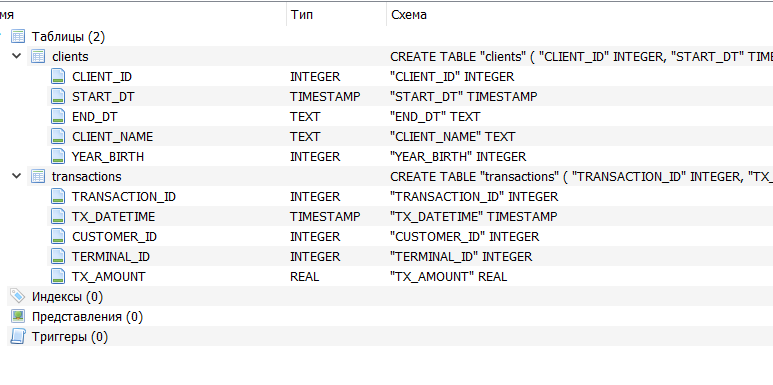

# Шаг 2. Запросы к базе данных

In [13]:
# Напишем функцию для запросов
def select_query(query, con = CON):
    try:
        cursor = CON.cursor()
        cursor.execute(query)
        record = cursor.fetchall()
        return record
        cursor.close()
    except sqlite3.Error as error:
        print(error)

### a. Вывести список всех клиентов, у которых между двумя ближайшими транзакциями был перерыв больше 35 дней хотя бы один раз (клиент должен быть действующим, то есть дата закрытия записи о клиенте не должна быть меньше дня относительно которого мы считаемся).       

План запроса:

1. С помощью lag выведем предыдущее значение даты для каждой транзакции в рамках каждого действующего клиента
2. Посчитаем разницу между датой текущей и предыдущей транзакции
3. Сделаем этот запрос подзапросом и отберем из него только те транзакции, где разница больше 35.
4. Выведем всех клиентов по этому параметру, отобрав максимальную из всех разниц в качестве бонуса.


In [14]:
query = 'select CLIENT_NAME, max(n_days) max_n_days\
            from\
                (select c.CLIENT_NAME, t.TX_DATETIME,\
                        lag(t.TX_DATETIME,1) over w previoius,\
                        round(JULIANDAY(t.TX_DATETIME) - JULIANDAY(lag(t.TX_DATETIME,1) over w)) as n_days\
                    from transactions t join clients c on t.CUSTOMER_ID = c.CLIENT_ID\
                    where date(c.END_DT) >= date("2023-05-01")\
                    window w as (PARTITION by c.CLIENT_NAME order by t.TX_DATETIME )\
                    order by c.CLIENT_NAME) t\
            where n_days > 35\
            group by CLIENT_NAME'

pd.DataFrame(select_query(query), columns = ['Client_name', 'Max_days_TX'])

,Client_name,Max_days_TX
0,Adler,36.0
1,Amila,57.0
2,Avionna,83.0
3,Blakley,56.0
4,Choyce,41.0
5,Dearra,45.0
6,Delyla,39.0
7,Elleigh,37.0
8,Emaline,58.0
9,Empress,54.0


### b. Вывести список клиентов, у которых максимальная сумма транзакции (имеется ввиду максимальное значение TX_AMOUNT) больше 50000. В ответе должен быть id клиента, максимальное значение суммы транзакций, минимальное значение суммы транзакций (клиент должен быть действующим, то есть дата закрытия записи о клиенте не должна быть меньше дня относительно которого мы считаемся).

План запроса:

1. Определим по каждому действующему клиенту максимальную и минимальную сумму транзакции
2. Сделаем этот запрос в качестве подзапроса и отберем из него только те, где максимальная величина транзакции больше 50000

In [15]:
query = 'select CLIENT_ID, max_TX_amount, min_TX_amount\
        from\
            (select distinct c.CLIENT_ID, max(t.TX_AMOUNT) over w max_TX_amount,\
                                min(t.TX_AMOUNT) over w min_TX_amount\
            from transactions t join clients c on t.CUSTOMER_ID = c.CLIENT_ID\
                where date(c.END_DT) >= date("2023-05-01")\
            window w as (PARTITION by c.CLIENT_NAME)\
            order by c.CLIENT_ID) t\
        where max_TX_amount > 50000'

pd.DataFrame(select_query(query), columns = ['Client_ID', 'MAX_TX_amount','MIN_TX_amount'])

,Client_ID,MAX_TX_amount,MIN_TX_amount
0,3013,77212.50,1.46
1,3494,53213.00,85.76
2,4253,51937.25,37.95


### c. Вывести топ-10 клиентов (сортируя их по убыванию id), у которых сумма дневных транзакций больше суммы вечерних транзакций Условимся, что дневными считаются транзакции, которые были произведены до 12 часов, а вечерними - после 12 часов включительно. (клиент должен быть действующим, то есть дата закрытия записи о клиенте не должна быть меньше дня относительно которого мы считаемся).

План запроса:

1. Для всех действующих клиентов внесем флаг для каждой транзакции в зависимости от часа ее свершения: если час находится между 00 и 11, то это будет флаг "day", если между 12 и 24, то "evening".
2. С помощью case посчитаем условную сумму по каждому флагу, поспользовшись группировкой по ID клиента и используя предыдущий запрос в качестве вложенного
3. Отберем из предыдущего запроса только те, в которых дневная суммы больше вечерней
4. Отсортируем финальный запрос по ID клиента в убывающем порядке и отберем с помощью limit только 10 первых строк

In [16]:
query = 'select CUSTOMER_ID, TX_day, TX_evening\
            from\
                (select CUSTOMER_ID, sum(case when TX_time = "day" then TX_AMOUNT else 0 END) TX_day,\
                                    sum(case when TX_time = "evening" then TX_AMOUNT else 0 END) TX_evening\
                from\
                    (select t.CUSTOMER_ID, t.TX_AMOUNT, t.TX_DATETIME,\
                        case when strftime("%H", t.TX_DATETIME) in ("00","01", "02", "03", "04", "05",\
                                                              "06", "07", "08", "09", "10", "11") then "day"\
                             else "evening" end TX_time\
                    from transactions t join clients c on t.CUSTOMER_ID = c.CLIENT_ID\
                    where date(c.END_DT) >= date("2023-05-01")\
                    ) t\
                group by CUSTOMER_ID) fin\
            where (TX_day > TX_evening) \
            order by CUSTOMER_ID desc\
            limit 10'

pd.DataFrame(select_query(query), columns = ['Customer_ID', 'TX_day', 'TX_evening'])

,Customer_ID,TX_day,TX_evening
0,4997,68153.52,63135.10
1,4993,43648.09,41244.55
2,4990,86921.94,86536.14
3,4987,12239.39,11547.78
4,4983,109737.94,97444.22
5,4982,45214.41,40213.19
6,4978,3210.61,3001.03
7,4976,71894.97,61467.88
8,4973,65297.68,64986.58
9,4972,3092.83,2702.23


### d. Найти для каждого клиента день, когда у него была максимальная сумма транзакции, то есть вывести клиента, дату транзакции, сумму транзакции (клиент должен быть действующим, то есть дата закрытия записи о клиенте не должна быть меньше дня относительно которого мы считаемся)

Данную задачу будем решать 2-мя способами, так как не совсем понятно, что такое максимальная сумма транзакции за день.

**Вариант решения 1**: выбраем максимальную сумму за транзакцию без суммирования за день, если они были.

План запроса:

1. По каждому действующему клиенту определим максимальную сумму единичной транзакции (под-таблица t)
2. Получим список всех транзакций по каждому клиенту (под-таблица t1)
3. Объединим обе таблицы по условию равенства ID и суммы транзакции максимальному значению (перечисление таблиц через запятую равносильно inner join). Это делается для того, если у одного клиента в разные даты будет одинаковая максимальная сумма единичной транзакции. Из объединенной таблицы получим запрашиваемую информацию, указав дату в формате месяц-день



**Вариант решения 2**: суммируем транзакции за день и отбираем максимальную как сумму всех транзакций за день

Порядок запроса аналогичен варианту 1, единственное максимум вычисляем по сумме транзакций за день, а не по единичной транзакции.

In [17]:
# Для решения определим максимум для каждого клиента и по нему отберем записи для даты

query = 'select t.CUSTOMER_ID, strftime("%m-%d", t1.TX_DATETIME), t.Max_TX_amount\
    from \
        (select DISTINCT t.CUSTOMER_ID, max(t.TX_AMOUNT) over (PARTITION by t.CUSTOMER_ID) Max_TX_amount\
                from transactions t join clients c on t.CUSTOMER_ID = c.CLIENT_ID\
                where date(c.END_DT) >= date("2023-05-01")\
                )t,\
        (select t.CUSTOMER_ID, t.TX_AMOUNT, t.TX_DATETIME\
                from transactions t join clients c on t.CUSTOMER_ID = c.CLIENT_ID\
                where date(c.END_DT) >= date("2023-05-01")\
                )t1\
    where t.CUSTOMER_ID = t1.CUSTOMER_ID and t.Max_TX_amount = t1.TX_AMOUNT \
    order by t.CUSTOMER_ID'

pd.DataFrame(select_query(query), columns = ['Customer_ID', 'TX_Month_Day', 'Max_TX_amount'])

,Customer_ID,TX_Month_Day,Max_TX_amount
0,0,02-01,1258.86
1,1,02-07,17152.00
2,2,02-21,1720.11
3,5,03-21,1156.11
4,6,03-20,369.26
...,...,...,...
3731,4991,01-25,1070.26
3732,4992,03-10,839.03
3733,4993,01-13,1054.57
3734,4996,01-11,224.62


In [18]:
query = 'select t1.CUSTOMER_ID, t1.month_day, t1.day_sum\
    FROM\
        (select distinct t.CUSTOMER_ID, strftime("%m-%d", t.TX_DATETIME) month_day, sum(t.TX_AMOUNT) over w day_sum\
                                from transactions t join clients c on t.CUSTOMER_ID = c.CLIENT_ID\
                                            where date(c.END_DT) >= date("2023-05-01")\
                                window w as (partition by t.CUSTOMER_ID, strftime("%m-%d", t.TX_DATETIME))\
                            order by t.CUSTOMER_ID, strftime("%m-%d", t.TX_DATETIME)) t1,\
        (select distinct CUSTOMER_ID, max(day_sum) over (PARTITION by CUSTOMER_ID) max_daily_amount\
        from \
            (select distinct t.CUSTOMER_ID, strftime("%m-%d", t.TX_DATETIME) month_day, sum(t.TX_AMOUNT) over w day_sum\
                            from transactions t join clients c on t.CUSTOMER_ID = c.CLIENT_ID\
                                        where date(c.END_DT) >= date("2023-05-01")\
                            window w as (partition by t.CUSTOMER_ID, strftime("%m-%d", t.TX_DATETIME))\
                        order by t.CUSTOMER_ID, strftime("%m-%d", t.TX_DATETIME)) t) t2\
    where t1.CUSTOMER_ID = t2.CUSTOMER_ID and t1.day_sum = t2.max_daily_amount'

pd.DataFrame(select_query(query), columns = ['Customer_ID', 'TX_Month_Day','MAX_day_sum'])

,Customer_ID,TX_Month_Day,MAX_day_sum
0,0,02-01,4084.94
1,1,01-28,19318.16
2,2,04-14,6190.41
3,5,03-17,4906.86
4,6,04-12,1504.53
...,...,...,...
3731,4991,01-09,3030.25
3732,4992,03-01,2733.89
3733,4993,02-21,2953.64
3734,4996,01-25,784.33


### e. Вычислить интегральное распределение суммы транзакций для каждого дня за весь период, то есть вывести дату транзакции, сумму транзакции и интегральное распределение по сумме (не учитываем что клиент может быть недействующим)

Решаем задачу 2 способами, так как непонятно, нужно ли вычислить распределение суммы транзакций в рамках одного дня за весь период или транзакций одного дня в рамках всех дней.

**Вариант 1**: транзакции за день суммируются и вычисляется распределение суммарных транзакций за день в рамках всех дней

План запроса:
1. Считаем сумму по транзакциям за каждый день
2. Из полученного запроса составляем распределение (сколько значений в % больше или равно текущему):cume_dist_% с учетом текущего, percent_rank_% без учета текущего

**Вариант 2**: транзакции за день не суммируются, вычисляется распределение транзакций одного дня в рамках этого дня

План запроса:
Составляем распределение сумм транзакий в рамках дня без учета времени транзакции: cume_dist_% с учетом текущего, percent_rank_% без учета текущего


In [19]:
# Вариант 1
query = 'select year_month_day, daily_total, round((cume_dist() over (order by daily_total))*100) total_split_percentage,\
            round((percent_rank() over (order by daily_total))*100) total_split_percentage_wo_current\
        from\
            (select distinct strftime("%Y-%m-%d", TX_DATETIME) year_month_day, round(sum(TX_AMOUNT) over w) daily_total\
            from transactions\
            window w as (PARTITION by strftime("%Y-%m-%d", TX_DATETIME))) t'
pd.DataFrame(select_query(query), columns = ['year_month_day', 'TX_daily_total', 'Cume_dist_%', 'Percent_rank_%'])

,year_month_day,TX_daily_total,Cume_dist_%,Percent_rank_%
0,2023-04-20,1795236.0,1.0,0.0
1,2023-01-01,4827656.0,2.0,1.0
2,2023-01-02,4862551.0,3.0,2.0
3,2023-01-04,4938142.0,4.0,3.0
4,2023-02-21,4968545.0,5.0,4.0
...,...,...,...,...
105,2023-02-09,5364510.0,96.0,96.0
106,2023-04-01,5383710.0,97.0,97.0
107,2023-04-06,5429040.0,98.0,98.0
108,2023-01-23,5509343.0,99.0,99.0


In [20]:
# Вариант 2
query = 'select distinct TX_DATETIME, TX_AMOUNT, strftime("%Y-%m-%d", TX_DATETIME) year_month_day,\
            round((cume_dist() over w) *100) cume_dist_perc, round((percent_rank() over w) *100) percent_rank_perc\
            from transactions\
        window w as (PARTITION 	by strftime("%Y-%m-%d", TX_DATETIME) order by TX_AMOUNT)'

pd.DataFrame(select_query(query), columns = ['TX_full_date', 'TX_amount', 'TX_year_month_day',\
                                                                           'Cume_dist_%', 'Percent_rank_%'])

# Ответ выглядит не очень, наверное все-таки нужным был вариант 1 

,TX_full_date,TX_amount,TX_year_month_day,Cume_dist_%,Percent_rank_%
0,2023-01-01 14:24:08,0.81,2023-01-01,0.0,0.0
1,2023-01-01 06:10:41,1.02,2023-01-01,0.0,0.0
2,2023-01-01 15:02:47,1.03,2023-01-01,0.0,0.0
3,2023-01-01 10:40:59,1.08,2023-01-01,0.0,0.0
4,2023-01-01 12:35:54,1.36,2023-01-01,0.0,0.0
...,...,...,...,...,...
1048570,2023-04-20 09:28:55,13024.50,2023-04-20,100.0,100.0
1048571,2023-04-20 09:51:58,18554.25,2023-04-20,100.0,100.0
1048572,2023-04-20 06:44:12,19174.75,2023-04-20,100.0,100.0
1048573,2023-04-20 05:16:06,19740.75,2023-04-20,100.0,100.0
